# AIcrowd Counting Barrels Challenge

## Barrel Count using CNN and Transfer Learning (VGG16)

In [135]:
from pathlib import Path
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np

!pip install git+https://gitlab.aicrowd.com/aicrowd/aicrowd-cli.git >/dev/null
%load_ext aicrowd.magic

API_KEY = "906daefa5cd971fd9e089a213054d8ed"
%aicrowd login --api-key $API_KEY

  Running command git clone -q https://gitlab.aicrowd.com/aicrowd/aicrowd-cli.git /tmp/pip-req-build-w8jmlhpg
The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic
API Key valid
Saved API Key successfully!


In [3]:
%aicrowd dataset list -c hey-barrels
%aicrowd dataset download -c hey-barrels -j 3

              Datasets for challenge #750                                       
┌───┬────────────────────────┬─────────────┬───────────┐                        
│ # │ Title                  │ Description │      Size │                        
├───┼────────────────────────┼─────────────┼───────────┤                        
│ 0 │ example_submission.csv │ -           │   7.45 KB │                        
│ 1 │ test.zip               │ -           │ 485.96 MB │                        
│ 2 │ train.zip              │ -           │ 494.61 MB │                        
└───┴────────────────────────┴─────────────┴───────────┘                        


In [4]:
!unzip train.zip >/dev/null
!unzip test.zip >/dev/null

In [113]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

TRAIN_DATA_DIR = "train/images"
TRAIN_LABELS = "train/meta-data.csv"
TEST_DATA_DIR = "test"
TRAIN_DATA = {}

for im in Path(TRAIN_DATA_DIR).iterdir():
    # scale down image
    # print(im.name)
    # img = cv2.imread(str(im))
    # print(img.shape)
    # break
    image = load_img(str(im), target_size=(224, 224))
    image = img_to_array(image)
    TRAIN_DATA[im.name] = image


X = np.array(list(TRAIN_DATA.values()))
Y = pd.read_csv(TRAIN_LABELS, index_col="filename").reindex(TRAIN_DATA.keys())
# Y = Y.drop(columns=["pigs_count"])
# Y.head()

(224, 224, 3)


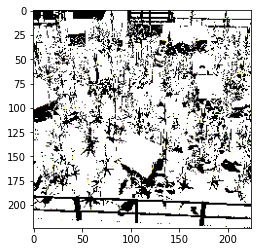

In [115]:
import matplotlib.pyplot as plt

plt.imshow(X[0])
print(X[0].shape)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=200)

In [117]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(400, 224, 224, 3)
(400, 2)
(100, 224, 224, 3)
(100, 2)


In [44]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [123]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = True
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(16, activation="relu")(bboxHead)
bboxHead = Dense(2)(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [124]:
opt = Adam(learning_rate=0.0001)
model.compile(loss="mse", optimizer=opt)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

In [ ]:
# model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
# model.summary()

In [ ]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=32, epochs=8)

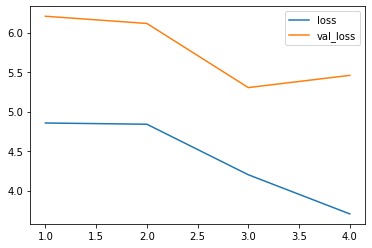

In [127]:
losses = pd.DataFrame(model.history.history)
losses=losses[1:]
losses.plot()

In [128]:
preds = model.predict(X_test)

In [ ]:
X_test

In [130]:
TEST_DATA = {}
for im in Path(TEST_DATA_DIR).iterdir():
    # scale down image
    image = load_img(str(im), target_size=(224, 224))
    image = img_to_array(image)
    TEST_DATA[im.name] = image

X_test_sub = np.array(list(TEST_DATA.values()))

In [ ]:
X_test_sub

In [132]:
y_test_sub = model.predict(X_test_sub)
# we cant have -ve sheeps and barrels...
y_test_sub[y_test_sub < 0] = 0
# ...or a fractional number of them
y_test_sub = y_test_sub.astype("int")

In [133]:
submission = pd.DataFrame(zip(TEST_DATA.keys(), y_test_sub[:,0], y_test_sub[:,1]), columns=["filename", "barrels_count", "pigs_count"]).sort_values("filename")
submission.to_csv("submission.csv", index=False)

In [136]:
%aicrowd submission create -c hey-barrels -f submission.csv

Submission limit reached for your account, it will reset at 2021-03-04 07:23:03 UTC


In [109]:
submission = pd.DataFrame(y_test_sub)

In [110]:
submission

,0
0,11
1,9
2,10
3,7
4,9
...,...
495,7
496,7
497,8
498,9


In [111]:
submission.to_csv("cb_fs.csv")